# 时序差分算法

教程链接：[时序差分算法](https://hrl.boyuai.com/chapter/1/%E6%97%B6%E5%BA%8F%E5%B7%AE%E5%88%86%E7%AE%97%E6%B3%95)

对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的状态转移概率是无法写出来的，也就无法直接进行动态规划。在这种情况下，智能体只能和环境进行交互，通过采样到的数据来学习，这类学习方法统称为**无模型的强化学习**（model-free reinforcement learning）。

不同于动态规划算法，无模型的强化学习算法不需要事先知道环境的奖励函数和状态转移函数，而是直接使用和环境交互的过程中采样到的数据来学习，这使得它可以被应用到一些简单的实际场景中。

本章还会引入一组概念：在线策略学习和离线策略学习。通常来说，**在线策略学习**要求使用在当前策略下采样得到的样本进行学习，一旦策略被更新，当前的样本就被放弃了，就好像在水龙头下用自来水洗手；而离线策略学习使用经验回放池将之前采样得到的样本收集起来再次利用，就好像使用脸盆接水后洗手。因此，**离线策略学习**往往能够更好地利用历史数据，并具有更小的样本复杂度（算法达到收敛结果需要在环境中采样的样本数量），这使其被更广泛地应用。

## 1. Sarsa算法

仍然在悬崖漫步环境下尝试 Sarsa 算法，与之前不同，此时环境不需要提供奖励函数和状态转移函数，而需要提供一个和智能体进行交互的函数step()，该函数将智能体的动作作为输入，输出奖励和下一个状态给智能体。

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库
from typing import Tuple


class CliffWalkingEnv:
    def __init__(self, ncol:int, nrow:int):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action:int) -> Tuple[int, int, bool]:  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self) -> int:  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [21]:
class Policy:
    """算法基类"""
    def __init__(self, ncol:int, nrow:int, epsilon:float, alpha:float, gamma:float, n_action:int=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state:int) -> int:  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state:int) -> int:  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, *args, **argv):
        raise NotImplementedError

In [22]:
class Sarsa(Policy):
    """ Sarsa算法 """
    def __init__(self, ncol:int, nrow:int, epsilon:float, alpha:float, gamma:float, n_action:int=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)

    def update(self, s0:int, a0:int, r:float, s1:int, a1:int):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3922.33it/s, episode=500, return=-18.900]


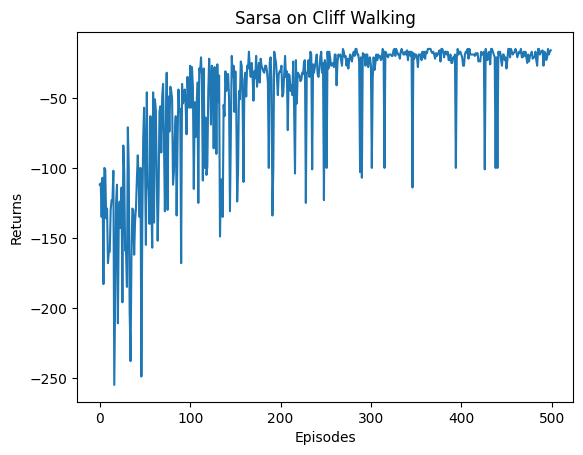

In [23]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [24]:
def print_agent(agent:Policy, env:CliffWalkingEnv, action_meaning:list[str], disaster:list=[], end:list=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## 2. 多步Sarsa算法

总的来说，蒙特卡洛方法是无偏（unbiased）的，但是具有比较大的方差。时序差分算法具有非常小的方差，因为只关注了一步状态转移，用到了一步的奖励，但是它是有偏的，因为用到了下一个状态的价值估计而不是其真实的价值。那有没有什么方法可以结合二者的优势呢？答案是**多步时序差分**！

In [25]:
class nstep_Sarsa(Policy):
    """ n步Sarsa算法 """
    def __init__(self, n:int, ncol:int, nrow:int, epsilon:float, alpha:float, gamma:float, n_action:int=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)

        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def update(self, s0:int, a0:int, r:float, s1:int, a1:int, done:bool):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3204.74it/s, episode=500, return=-19.100]


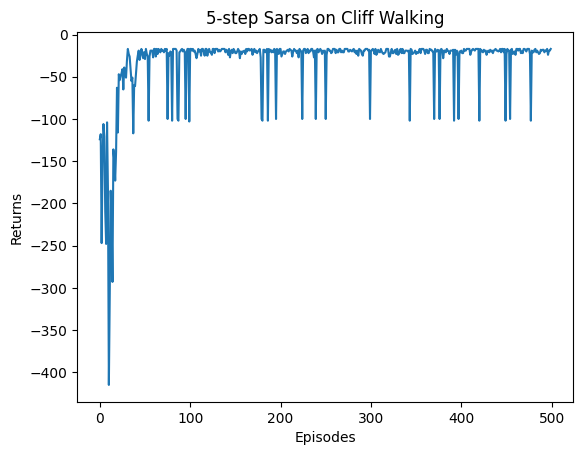

In [26]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [27]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## 3. Q-learning 算法

我们称采样数据的策略为行为策略（behavior policy），称用这些数据来更新的策略为目标策略（target policy）。在线策略（on-policy）算法表示行为策略和目标策略是同一个策略；而离线策略（off-policy）算法表示行为策略和目标策略不是同一个策略。Sarsa 是典型的在线策略算法，而 Q-learning 是典型的离线策略算法。判断二者类别的一个重要手段是看计算时序差分的价值目标的数据是否来自当前的策略。
- 对于 Sarsa，它的更新公式必须使用来自当前策略采样得到的五元组$(s,a,r,s^\prime,a^\prime)$，因此它是在线策略学习方法；
- 对于 Q-learning，它的更新公式使用的是四元组$(s,a,r,s^\prime)$来更新当前状态动作对的价值$Q(s,a)$，数据中的$s$和$a$是给定的条件，$r$和$s^\prime$皆由环境采样得到，该四元组并不需要一定是当前策略采样得到的数据，也可以来自行为策略，因此它是离线策略算法。

In [28]:
class QLearning(Policy):
    """ Q-learning算法 """
    def __init__(self, ncol:int, nrow:int, epsilon:float, alpha:float, gamma:float, n_action:int=4):
        super().__init__(ncol, nrow, epsilon, alpha, gamma, n_action)

    def update(self, s0:int, a0:int, r:float, s1:int):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3999.91it/s, episode=500, return=-61.700]


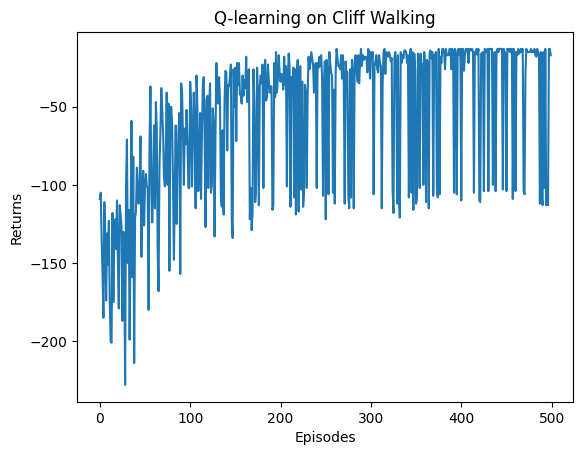

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [29]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

仔细观察 Sarsa 和 Q-learning 在训练过程中的回报曲线图，我们可以发现，在一个序列中 Sarsa 获得的期望回报是高于 Q-learning 的。这是因为在训练过程中智能体采取基于当前$Q(s,a)$函数的$\epsilon$-贪婪策略来平衡探索与利用，Q-learning 算法由于沿着悬崖边走，会以一定概率探索“掉入悬崖”这一动作，而 Sarsa 相对保守的路线使智能体几乎不可能掉入悬崖。